# Neanderthal 3D genome

by Evonne McArthur

Jupyter notebook for analysis and figure-generating code for the paper: 

Github:

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-dependencies,-import-model,-and-specify-paths" data-toc-modified-id="Import-dependencies,-import-model,-and-specify-paths-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import dependencies, import model, and specify paths</a></span></li><li><span><a href="#Functions-to-extract,-run,-format,-and-visualize-3D-genome-predictions" data-toc-modified-id="Functions-to-extract,-run,-format,-and-visualize-3D-genome-predictions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions to extract, run, format, and visualize 3D genome predictions</a></span></li><li><span><a href="#Fig-2---AH-&amp;-MH-3D-divergence-across-the-genome" data-toc-modified-id="Fig-2---AH-&amp;-MH-3D-divergence-across-the-genome-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fig 2 - AH &amp; MH 3D divergence across the genome</a></span><ul class="toc-item"><li><span><a href="#Generating-3D-genomes" data-toc-modified-id="Generating-3D-genomes-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generating 3D genomes</a></span></li><li><span><a href="#Comparing-3D-genomes" data-toc-modified-id="Comparing-3D-genomes-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Comparing 3D genomes</a></span></li><li><span><a href="#Reading-in-comparisons" data-toc-modified-id="Reading-in-comparisons-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Reading in comparisons</a></span></li><li><span><a href="#Fig-2A" data-toc-modified-id="Fig-2A-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Fig 2A</a></span></li><li><span><a href="#Fig-2B" data-toc-modified-id="Fig-2B-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Fig 2B</a></span><ul class="toc-item"><li><span><a href="#Example-1" data-toc-modified-id="Example-1-3.5.1"><span class="toc-item-num">3.5.1&nbsp;&nbsp;</span>Example 1</a></span></li><li><span><a href="#Example-2" data-toc-modified-id="Example-2-3.5.2"><span class="toc-item-num">3.5.2&nbsp;&nbsp;</span>Example 2</a></span></li><li><span><a href="#Example-3" data-toc-modified-id="Example-3-3.5.3"><span class="toc-item-num">3.5.3&nbsp;&nbsp;</span>Example 3</a></span></li><li><span><a href="#Example-4" data-toc-modified-id="Example-4-3.5.4"><span class="toc-item-num">3.5.4&nbsp;&nbsp;</span>Example 4</a></span></li></ul></li><li><span><a href="#Fig-2C" data-toc-modified-id="Fig-2C-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Fig 2C</a></span></li></ul></li></ul></div>

## Import dependencies, import model, and specify paths

To ensure the proper packages are downloaded, use the conda environment `nean_3d` available in the `environment.yml` file

In [9]:
### Figures and basic packages used ###

# Figures
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('default') # set to your personal preference
import matplotlib.font_manager
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the figure title

import seaborn as sns
sns.set(color_codes=True) # Seaborn desaturates matplotlib colors (this is useful if you use both seaborn and basic matplot lib and want colors to be consistent)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys
sys.setrecursionlimit(5000)

import numpy as np
np.random.seed(42)
import pandas as pd
import scipy.stats as stats


In [3]:
### For running Akita (CNN for predicting 3d genome organization) ###
# Details here: https://github.com/calico/basenji/blob/master/manuscripts/akita/

import os
import json
import subprocess
os.environ["CUDA_VISIBLE_DEVICES"] = '-1' ### run on CPU

import tensorflow as tf
print(tf.__version__)
if tf.__version__[0] == '1':
    tf.compat.v1.enable_eager_execution()

import pysam
from cooltools.lib.numutils import set_diag

from basenji import dataset, dna_io, seqnn
from matplotlib.pyplot import xticks, yticks
from scipy import stats
from multiprocessing import  Pool

import warnings
from itertools import chain


1.15.0


In [4]:
### load params, specify model ###

model_dir = './akita_model/'
params_file = model_dir+'params.json'
model_file  = model_dir+'model_best.h5'
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seqnn_model = seqnn.SeqNN(params_model)

### restore model ###
seqnn_model.restore(model_file)

### read data parameters ###
data_stats_file = model_dir+'/statistics.json'
with open(data_stats_file) as data_stats_open:
    data_stats = json.load(data_stats_open)
seq_length = data_stats['seq_length']
target_length = data_stats['target_length']
hic_diags =  data_stats['diagonal_offset']
target_crop = data_stats['crop_bp'] // data_stats['pool_width']
target_length1 = data_stats['seq_length'] // data_stats['pool_width']


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, 1048576, 4)] 0                                            
__________________________________________________________________________________________________
stochastic_reverse_complement ( ((None, 1048576, 4), 0           sequence[0][0]                   
__________________________________________________________________________________________________
stochastic_shift (StochasticShi (None, 1048576, 4)   0           stochastic_reverse_complement[0][
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 1048576, 4)   0           stochastic_shift[0][0]           
____________________________________________________________________________________________

## Functions to extract, run, format, and visualize 3D genome predictions
Largely adapted from  https://github.com/calico/basenji/blob/master/manuscripts/akita/explore_model.ipynb

In [17]:
### for converting from flattened upper-triangluar vector to symmetric matrix  ###
def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

target_length1_cropped = target_length1 - 2*target_crop
print('flattened representation length:', target_length) 
print('symmetrix matrix size:', '('+str(target_length1_cropped)+','+str(target_length1_cropped)+')')


### This finds fasta files locally, change path to the location of the fasta genomes on your machine ###
def find_inFileLoc(indiv, chrm):
    if (indiv == "vindija") | (indiv == "altai") | (indiv == "denisova") | (indiv == "chagyrskaya"):   # if archaic
        in_file_loc = '/gpfs51/dors2/capra_lab/users/rinkerd/projects/3DNeand/data/genomes/%s/%s%s_hg19_masked.fa' % (indiv,chrm,indiv)
    elif 'SAS' not in indiv:
        in_file_loc = '/gpfs51/dors2/capra_lab/users/rinkerd/projects/3DNeand/data/genomes/1KG.individuals/%s/%s_%s_hg19_full.fa' % (indiv,chrm,indiv.split("_")[3])
    else:
        in_file_loc = '/dors/capra_lab/users/erin/RotationProject_Akita/data/genomes/1KG/%s/%s_%s_hg19_full.fa' % (indiv,chrm,indiv.split("_")[3])

    return in_file_loc

### Run Akita 3d genome predictions ###
def runAkitaPreds(seq):
    if len(seq) != 2**20: raise ValueError('len(seq) != seq_length')
    seq_1hot = dna_io.dna_1hot(seq)
    test_pred_from_seq = seqnn_model.model.predict(np.expand_dims(seq_1hot,0))
    return test_pred_from_seq

### Object that gets the sequence and 3d genome predictions for a window for a given individual ###
class extractFastaRunAkita:
    def __init__(self, indiv, chrm, start_loc):
        in_file_loc_indiv = find_inFileLoc(indiv, chrm)
        try:
            indiv_fasta_open = pysam.Fastafile(in_file_loc_indiv)
        except OSError:
            in_file_loc_indiv = '/dors/capra_lab/users/erin/RotationProject_Akita/data/genomes/1KG/%s/%s_%s_hg19_full.fa' % (indiv,chrm,indiv.split("_")[3])
            indiv_fasta_open = pysam.Fastafile(in_file_loc_indiv)

        mask_fasta_open = pysam.Fastafile('/gpfs51/dors2/capra_lab/users/rinkerd/projects/3DNeand/data/genomes/masked_hg19_reference/%s_hg19_archaic.masked.fa' % chrm) #for the masked
        human19_fasta_open = pysam.Fastafile('/dors/capra_lab/data/dna/human/hg19/%s.fa' % chrm)

        #extract sequences
        indiv_seq = indiv_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper()
        masked_seq = mask_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper() #for the masked 
        human19_seq = human19_fasta_open.fetch(chrm, start_loc, start_loc+2**20).upper()

        # important harmonization step! then run predictions on the harmonized sequence
        indiv_fillMissing_seq = "".join([r if m == "N" else r if s == "N" else s for r, m, s in zip(human19_seq, masked_seq, indiv_seq)])
        self.seq = indiv_fillMissing_seq
        indiv_pred  = runAkitaPreds(indiv_fillMissing_seq)
        indiv_pred_hff = indiv_pred[:,:,0][0] # save only hff
        self.pred = indiv_pred_hff
        
### Visualize the 3D genome predictions compared between two individuals for a particular region ### 

def compare3Dpreds(indiv1, indiv2, chrm, start, markerLabelInterval=0.1, defaultColor=True, vmin=-2,vmax=2,saveFig=False, lowLim=0,hiLim=448,icons = None):
    end = start + 2**20
    viz_start = start + (32+lowLim)*2048
    viz_end= start +(32+hiLim)*2048
    marker_labels = np.arange(np.floor(start/100000)/10, np.ceil((end)/100000)/10,markerLabelInterval)
    marker_labels = marker_labels[(marker_labels > viz_start/1000000) & (marker_labels < viz_end/1000000)]

    marker_loc = [(x*1000000-(start+(32*2048)))/2048 for x in marker_labels]

    indiv1_vector = extractFastaRunAkita(indiv1,chrm,start)
    indiv1_mat = from_upper_triu(indiv1_vector.pred, target_length1_cropped, hic_diags)
    indiv2_vector = extractFastaRunAkita(indiv2,chrm,start)
    indiv2_mat = from_upper_triu(indiv2_vector.pred, target_length1_cropped, hic_diags)

    fig,ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3),gridspec_kw={'width_ratios': [3,3,3]});

    if not(defaultColor):
        cutoff = max(max(np.nanmax(indiv1_mat[lowLim:hiLim,lowLim:hiLim]),np.nanmax(indiv2_mat[lowLim:hiLim,lowLim:hiLim])),-1*min(np.nanmin(indiv1_mat[lowLim:hiLim,lowLim:hiLim]),np.nanmin(indiv2_mat[lowLim:hiLim,lowLim:hiLim])))
        vmax= cutoff
        vmin= -1*cutoff
        print(vmin,vmax)
        
        # Uncomment for custom legend
        #fig_legend,ax_legend = plt.subplots(figsize=(10,1.5));
        #ax_legend.matshow(np.array([np.linspace(vmin,vmax,100),np.linspace(vmin,vmax,100)]), cmap= 'RdBu_r', vmax=vmax, vmin=vmin);
        #ax_legend.set_xticks([99*(x-vmin)/(vmax-vmin) for x in [-1.5,-1.25,-1,-.75,-0.5,-0.25,0,.25,.5,.75,1,1.25,1.5]]);
        #ax_legend.set_xticklabels([-1.5,-1.25,-1,-.75,-0.5,-0.25,0,.25,.5,.75,1,1.25,1.5]);
        #plt.savefig("/home/mcarthe/legend.pdf")
        
    im = ax[0].matshow(indiv1_mat, cmap= 'RdBu_r', vmax=vmax, vmin=vmin);
    im = ax[1].matshow(indiv2_mat, cmap= 'RdBu_r', vmax=vmax, vmin=vmin);
    im = ax[2].matshow(indiv1_mat - indiv2_mat, cmap= 'PRGn_r', vmin=-0.5, vmax=0.5)    
    
    t = mpl.markers.MarkerStyle(marker='|');
    t._transform = t.get_transform().rotate_deg(-45);
        
    if icons != None:
        for i in icons:
            if isinstance(i, list): # for a region (like a gene)
                i_loc_start = (i[0]-(start+(32*2048)))/2048
                i_loc_end = (i[1]-(start+(32*2048)))/2048
                for i_loc in np.arange(i_loc_start,i_loc_end+0.25,0.25):
                    ax[0].scatter(x=i_loc,y=i_loc,marker = t,color='gray',s=50);
                    ax[1].scatter(x=i_loc,y=i_loc,marker = t,color='gray',s=50);
                    ax[2].scatter(x=i_loc,y=i_loc,marker = t,color='gray',s=50);
            else: # for a single point (like a snp)
                i_loc = (i-(start+(32*2048)))/2048
                ax[0].scatter(x=i_loc,y=i_loc,marker = '*',color='k',s=50);
                ax[1].scatter(x=i_loc,y=i_loc,marker = '*',color='k',s=50);
                ax[2].scatter(x=i_loc,y=i_loc,marker = '*',color='k',s=50);
                
    ax[0].scatter(x=marker_loc,y=marker_loc,marker = t,color='k',s=50);
    ax[1].scatter(x=marker_loc,y=marker_loc,marker = t,color='k',s=50);
    ax[2].scatter(x=marker_loc,y=marker_loc,marker = t,color='k',s=50);

    for loc,label in zip(marker_loc,marker_labels):
        _ = ax[0].text(loc - 15, loc+15, str(round(label,1)), horizontalalignment='center', verticalalignment='center', rotation=-45,fontsize=6);
        _ = ax[1].text(loc - 15, loc+15, str(round(label,1)), horizontalalignment='center', verticalalignment='center', rotation=-45,fontsize=6);
        _ = ax[2].text(loc - 15, loc+15, str(round(label,1)), horizontalalignment='center', verticalalignment='center', rotation=-45,fontsize=6);

    ax[0].title.set_text(indiv1)
    ax[1].title.set_text(indiv2)
    ax[0].set_xlim((lowLim,hiLim))
    ax[1].set_xlim((lowLim,hiLim))
    ax[2].set_xlim((lowLim,hiLim))
    ax[0].set_ylim((hiLim,lowLim))
    ax[1].set_ylim((hiLim,lowLim))
    ax[2].set_ylim((hiLim,lowLim))
    divergence = 1-stats.spearmanr(indiv1_vector.pred, indiv2_vector.pred)[0]
        
    print('%s:%s-%s 3D divergence score: %0.9f\nVisualized between %s:%s-%s' % (chrm, start, end, divergence,chrm,viz_start,viz_end))
    if saveFig:
        plt.savefig("/home/mcarthe/%s_%s_%s_%s.pdf" % (chrm, start,indiv1, indiv2))
    else:
        plt.show();
    # return indiv1_mat, indiv2_mat


flattened representation length: 99681
symmetrix matrix size: (448,448)


## Fig 2 - AH & MH 3D divergence across the genome

### Generating 3D genomes

### Comparing 3D genomes

### Reading in comparisons

### Fig 2A

### Fig 2B

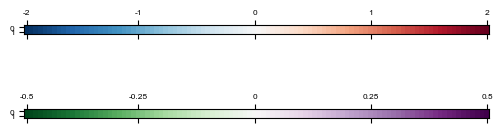

In [12]:
# Legend for 3d genome organization figures

fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(6,2));

ax[0].matshow(np.array([np.linspace(-2,2,100),np.linspace(-2,2,100)]), cmap= 'RdBu_r', vmax=2, vmin=-2);
ax[1].matshow(np.array([np.linspace(-0.5,0.5,100),np.linspace(-0.5,0.5,100)]), cmap= 'PRGn_r', vmax=0.5, vmin=-0.5);
ax[0].set_xticks([0,24,49,74,99]);
ax[0].set_xticklabels([-2,-1,0,1,2]);
ax[1].set_xticks([0,24,49,74,99]);
ax[1].set_xticklabels([-0.5,-.25,0,0.25,0.5]);
#plt.savefig("/home/mcarthe/legend.pdf");


#### Example 1

chr16:6291456-7340032 3D divergence score: 0.000678953
Visualized between chr16:6356992-7274496


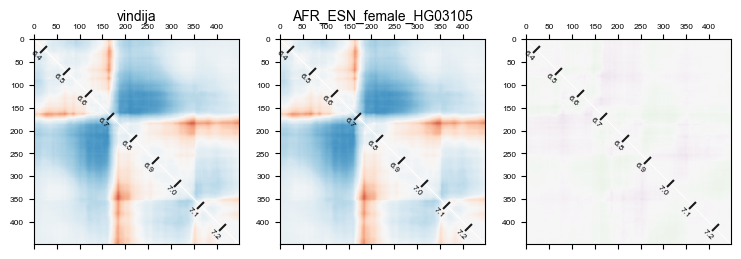

In [18]:
indiv1 = 'vindija'
indiv2 = 'AFR_ESN_female_HG03105'
chrm='chr16'
start = 6291456
compare3Dpreds(indiv1, indiv2, chrm, start)#, saveFig=True)
# chr16   6291456 0.7369852066040039      1.0     0.7295608520507812      1.0     0.9972105026245117 1.0 0.7341518402099609


#### Example 2

chr13:108003328-109051904 3D divergence score: 0.012364211
Visualized between chr13:108068864-108986368


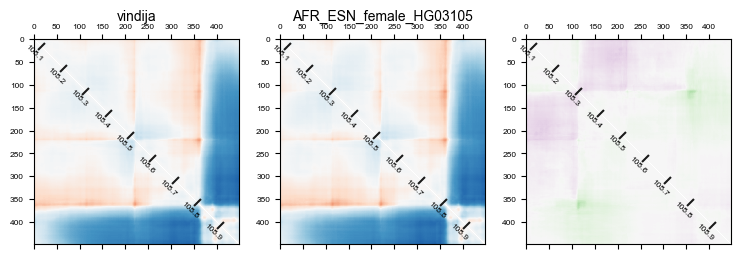

In [19]:
indiv1 = 'vindija'
indiv2 = 'AFR_ESN_female_HG03105'
chrm = 'chr13'
start = 108003328
compare3Dpreds(indiv1, indiv2, chrm, start)#, saveFig=True)

#### Example 3

chr1:233832448-234881024 3D divergence score: 0.043153852
Visualized between chr1:233897984-234815488


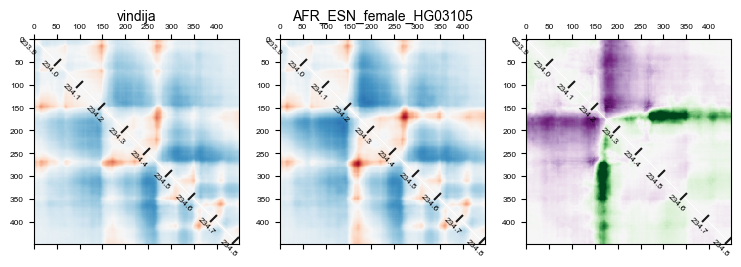

In [20]:
indiv1 = 'vindija'
indiv2 = 'AFR_ESN_female_HG03105'
chrm = 'chr1'
start = 233832448
compare3Dpreds(indiv1, indiv2, chrm, start)#, saveFig=True)

#### Example 4

chr5:24117248-25165824 3D divergence score: 0.287417937
Visualized between chr5:24182784-25100288


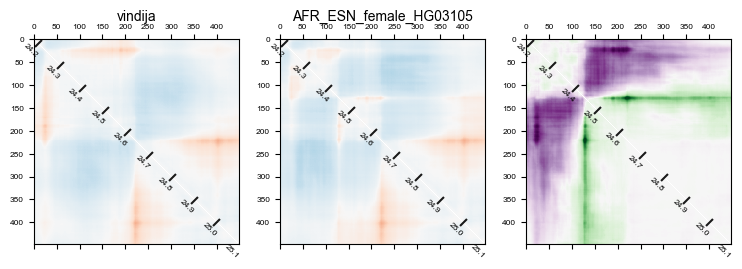

In [21]:
indiv1 = 'vindija'
indiv2 = 'AFR_ESN_female_HG03105'
chrm = 'chr5'
start = 24117248
#chr5    24117248        0.6796903610229492      1.0     0.6795988082885742      1.0     0.998814582824707       1.0     0.6785030364990234
compare3Dpreds(indiv1, indiv2, chrm, start)#, saveFig=True)

### Fig 2C